In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from utils import _DeepLiftShap, _GradCAMPlusPlus, SimpleUpsampling, ERFUpsampling,ERFUpsamplingFast, cut_model_from_layer, cut_model_to_layer
from data import PascalVOC2007
from results.results_metrics import ResultMetrics
from models import vgg11_PascalVOC

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

In [2]:
model = vgg11_PascalVOC()
model.to(device)
# Load the pretrained weights
model.load_state_dict(torch.load('VGG11_PascalVOC.pt', map_location=device))
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                 # Convert to Tensor
    transforms.Normalize(                  # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [3]:
test_data = PascalVOC2007("test", transform=preprocess)

Using downloaded and verified file: data\VOCtest_06-Nov-2007.tar
Extracting data\VOCtest_06-Nov-2007.tar to data


In [14]:
import torch.utils
from torch.utils.data import Subset

BATCH_SIZE_TEST = 8
NUM_TEST = 128

dl_test = DataLoader(Subset(test_data, torch.randperm(len(test_data))[:NUM_TEST]), batch_size=BATCH_SIZE_TEST, shuffle=False)

In [15]:
from metrics import perturb_fn
from tqdm.auto import tqdm

differences = []

for i, (img, label) in tqdm(enumerate(dl_test)):
    img = img.to(device)
    label = label.to(device)
    
    output = model(img)

    for i in range(10):
        noise, perturbed_img = perturb_fn(img)
        output_perturbed = model(perturbed_img)

        differences.append(torch.norm(output - output_perturbed).detach().cpu().numpy())

0it [00:00, ?it/s]

In [32]:
differences = np.array(differences)

(array([1., 2., 0., 2., 1., 4., 0., 3., 2., 1., 2., 2., 2., 3., 3., 3., 3.,
        4., 2., 5., 2., 3., 1., 0., 4., 1., 1., 3., 2., 1., 1., 4., 2., 5.,
        3., 0., 3., 2., 0., 4., 1., 0., 1., 5., 3., 6., 2., 2., 4., 5., 3.,
        3., 1., 2., 1., 1., 1., 2., 3., 2., 1., 2., 1., 2., 1., 0., 2., 0.,
        1., 1., 1., 0., 1., 1., 0., 1., 3., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.14073895, 0.14316902, 0.14559907, 0.14802913, 0.1504592 ,
        0.15288925, 0.15531932, 0.15774937, 0.16017944, 0.1626095 ,
        0.16503955, 0.16746962, 0.16989969, 0.17232974, 0.17475981,
        0.17718986, 0.17961992, 0.18204999, 0.18448004, 0.18691011,
        0.18934017, 0.19177023, 0.19420029, 0.19663034, 0.19906041,
        0.20149048, 0.20392053, 0.20635059, 0.20878066, 0.21121071,
        0.21364078, 0.21607085, 0.2185009 , 0.22093096, 0.22336102,
        0.22579108, 0.22822115, 0.2306512 , 0.23308127, 0.23551133,
      

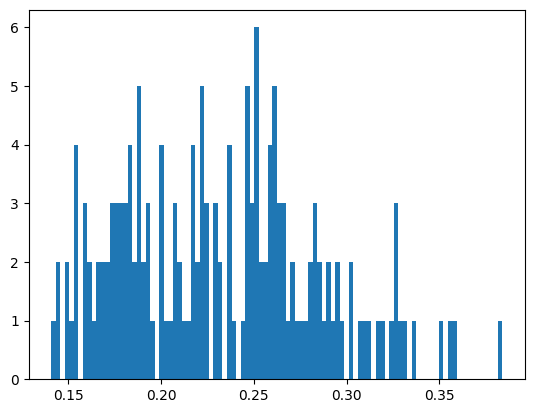

In [33]:
import matplotlib.pyplot as plt

plt.hist(differences, bins=100)

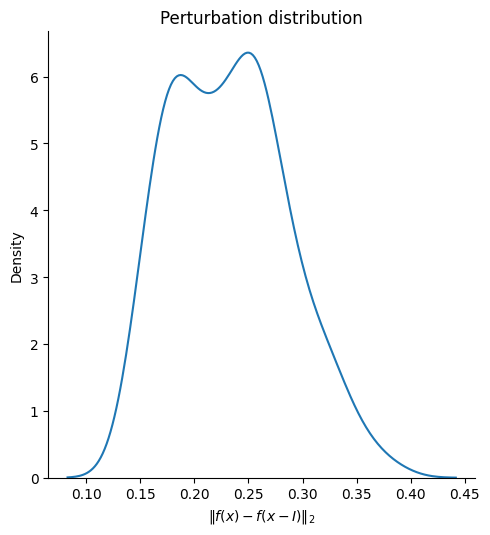

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(differences, kind="kde")
plt.xlabel("$\|f(x) - f(x - I)\|_2$")
plt.title("Perturbation distribution")
plt.savefig("perturbation_distribution.pdf", bbox_inches
            ='tight')